<a href="https://colab.research.google.com/github/sandeepangh782/ML-21CSC307P/blob/main/ML_Tutorial_decision_tree.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Suicide Risk Prediction

Let's import some required libraries before we begin.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import os
import warnings
%matplotlib inline

In [2]:
# Set some default options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
sns.set_style('darkgrid')
matplotlib.rcParams['font.size'] = 12
matplotlib.rcParams['figure.figsize'] = (10, 8)
matplotlib.rcParams['figure.facecolor'] = '#00000000'
warnings.filterwarnings('ignore')

# Download the Dataset

The file `master.csv` contains the data. Let's load it into a Pandas dataframe.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
raw_df = pd.read_csv('/content/drive/MyDrive/master.csv')
raw_df.head()

,country,year,sex,age,suicides_no,population,suicides/100k pop,country-year,HDI for year,gdp_for_year ($),gdp_per_capita ($),generation
0,Albania,1987,male,15-24 years,21,312900,6.71,Albania1987,NaN,"2,156,624,900",796,Generation X
1,Albania,1987,male,35-54 years,16,308000,5.19,Albania1987,NaN,"2,156,624,900",796,Silent
2,Albania,1987,female,15-24 years,14,289700,4.83,Albania1987,NaN,"2,156,624,900",796,Generation X
3,Albania,1987,male,75+ years,1,21800,4.59,Albania1987,NaN,"2,156,624,900",796,G.I. Generation
4,Albania,1987,male,25-34 years,9,274300,3.28,Albania1987,NaN,"2,156,624,900",796,Boomers


Let's look at the types of data and number of null values under each column.

In [5]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27820 entries, 0 to 27819
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   country             27820 non-null  object 
 1   year                27820 non-null  int64  
 2   sex                 27820 non-null  object 
 3   age                 27820 non-null  object 
 4   suicides_no         27820 non-null  int64  
 5   population          27820 non-null  int64  
 6   suicides/100k pop   27820 non-null  float64
 7   country-year        27820 non-null  object 
 8   HDI for year        8364 non-null   float64
 9    gdp_for_year ($)   27820 non-null  object 
 10  gdp_per_capita ($)  27820 non-null  int64  
 11  generation          27820 non-null  object 
dtypes: float64(2), int64(4), object(6)
memory usage: 2.5+ MB


There are leading and trailing spaces in the column name `gdp_for_year ($)`. Let's fix it.

In [6]:
raw_df.rename(columns={' gdp_for_year ($) ':'gdp_for_year ($)'}, inplace=True)
raw_df.columns

Index(['country', 'year', 'sex', 'age', 'suicides_no', 'population',
       'suicides/100k pop', 'country-year', 'HDI for year', 'gdp_for_year ($)',
       'gdp_per_capita ($)', 'generation'],
      dtype='object')

There are 6 numeric columns and 6 categorical columns. The column `HDI for year` contains a lot of missing values.


Next, we are going to clean up the data and explore the data to gain some quick insights.

# Data Cleaning and EDA

In this section, let's try to clean up the data and remove/add columns we need for subsequent analysis.

We see earlier that there are a lot of missing values in `HDI for year`. Let's start by manipulating this column.

In [7]:
raw_df.drop(columns=['country-year','HDI for year'], inplace=True)
raw_df.columns

Index(['country', 'year', 'sex', 'age', 'suicides_no', 'population',
       'suicides/100k pop', 'gdp_for_year ($)', 'gdp_per_capita ($)',
       'generation'],
      dtype='object')

In [8]:
# Group the data by country and find the sum of suicides number and population
suicide_by_country_df = raw_df.groupby('country')[['suicides_no', 'population']].sum().reset_index()

# Calculate suicides/100k pop
suicide_by_country_df['suicides/100k pop'] = 100000 * suicide_by_country_df['suicides_no'] / suicide_by_country_df['population']

# Sort the rows by suicides/100k pop from highest to lowest
suicide_by_country_df.sort_values(by='suicides/100k pop', ascending=False, inplace=True)
suicide_by_country_df.head()

,country,suicides_no,population,suicides/100k pop
52,Lithuania,28039,68085210,41.182219
75,Russian Federation,1209742,3690802620,32.777207
87,Sri Lanka,55641,182525626,30.483939
11,Belarus,59892,197372292,30.344685
40,Hungary,73891,248644256,29.717558


## Suicide Over Time

Let's take a look at the suicide incidence over the past 20 years.

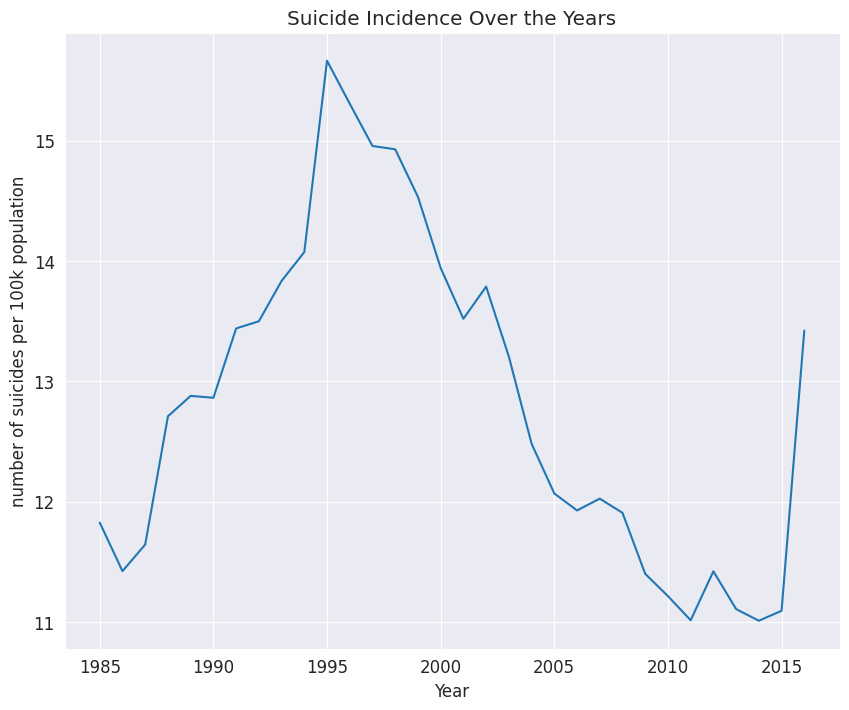

In [9]:
# x-axis from year 1985 to 2016
x = np.arange(1985, 2017)

# y-axis is the mean suicide no. per 100k population
y = raw_df.groupby('year')['suicides/100k pop'].mean()

# Create a line plot
sns.lineplot(x=x, y=y)
plt.xlabel('Year')
plt.ylabel('number of suicides per 100k population')
plt.title('Suicide Incidence Over the Years');

The suicide incidence of the countries in our dataset peaked in 1995 and followed a downtrend since then. However, in 2015, there was a sudden surge of number of suicides.

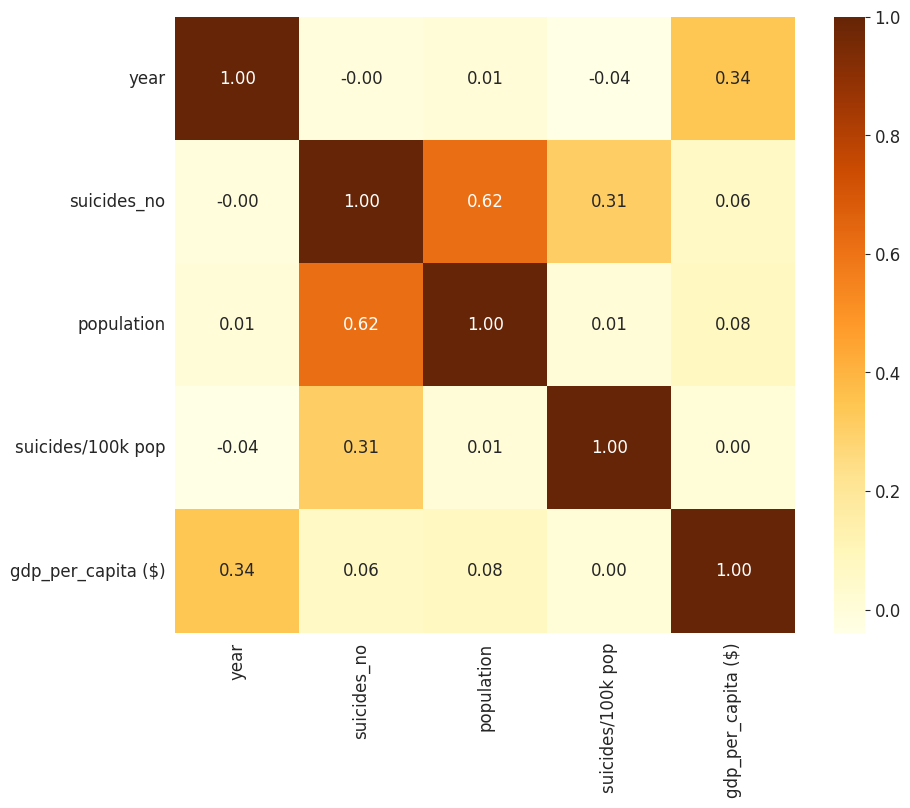

In [10]:
sns.heatmap(raw_df.corr(), annot=True, cmap='YlOrBr', fmt='.2f');

There doesn't seem to be strong relationship between numerical variables and suicide. The correlation coefficient between `population` and `suicides_no` is quite high (0.62), but actually there is no "real" correlation (coefficient = 0.01) after normalizing the number of suicides by population.

We've completed the EDA.

# Prepare the Data for Training



## Create the target column

Before we split the dataset into train/validation/test set, let's create our target column `suicide_risk` (i.e. high / low risk) using the information from `suicides/100k pop`.

If the value of `suicides/100k pop` is higher than the mean of `suicides/100k pop`, we will classify the suicide risk as high, and low otherwise.

In [11]:
# Create additional column for suicide risk and set the default value as low
raw_df['suicide_risk'] = 'low'

# Set the risk as high if suicides/100k pop is higher than the mean
raw_df.loc[raw_df['suicides/100k pop'] > raw_df['suicides/100k pop'].mean(), 'suicide_risk'] = 'high'
raw_df['suicide_risk'].value_counts()

low     19061
high     8759
Name: suicide_risk, dtype: int64

## Create Train, Validation and Test Sets

Let's split our dataset into three parts.

1.   Train set: used to train a model
2.   Validation set: used to tune model hyperparameters (e.g., regularization parameter) and choose between models during training
3.   Test set: used to compare different models and report the model's final accuracy
Let's look at the distribution fo our data by `year`.

It's a bit challenging to decide which year we should use as a split point by looking at the count. Let's look at the cumulative percentage instead.

In [12]:
# Create a series containing number of data per year
year_dt = raw_df.year.value_counts()
year_dt.sort_index(inplace=True)
cum_pct = 100 * year_dt.cumsum() / year_dt.sum()
cum_pct

1985      2.070453
1986      4.140906
1987      6.470165
1988      8.583753
1989     10.826743
1990     13.587347
1991     16.347951
1992     19.151689
1993     21.955428
1994     24.888569
1995     28.253055
1996     31.574407
1997     34.895758
1998     38.303379
1999     41.883537
2000     45.593098
2001     49.388929
2002     53.098490
2003     56.808052
2004     60.431344
2005     64.054637
2006     67.721064
2007     71.430625
2008     75.097052
2009     78.936017
2010     82.731848
2011     86.441409
2012     89.935298
2013     93.386053
2014     96.750539
2015     99.424874
2016    100.000000
Name: year, dtype: float64

Approximately 60% of data are before 2004 (cumulative percentage = 60.4%), and 20% of data are between 2005 and 2010 (cumulative percentage = 82.7%).

Let's split the data into train/validation/test set using year 2004 and year 2010 as breakpoint.

In [13]:
train_df = raw_df.loc[raw_df['year'] <= 2004]
val_df = raw_df.loc[(raw_df['year'] >= 2005) & (raw_df['year'] <=2010)]
test_df = raw_df.loc[raw_df['year'] >= 2011]

print('train_df.shape: ', train_df.shape)
print('val_df.shape: ', val_df.shape)
print('test_df.shape: ', test_df.shape)

train_df.shape:  (16812, 11)
val_df.shape:  (6204, 11)
test_df.shape:  (4804, 11)


## Identify Input and Target Columns

In [14]:
input_cols = ['country', 'sex', 'age','gdp_per_capita ($)']
target_col = 'suicide_risk'

In [15]:
train_inputs = train_df.loc[:, input_cols]
train_target = train_df.loc[:, target_col]

val_inputs = val_df.loc[:, input_cols]
val_target = val_df.loc[:, target_col]

test_inputs = test_df.loc[:, input_cols]
test_target = test_df.loc[:, target_col]

Let's also identify the numeric and categorical columns.

In [16]:
numeric_cols = list(train_inputs.select_dtypes(include=np.number).columns)
categorical_cols = list(train_inputs.select_dtypes(include='object').columns)

print('numeric columns: ', numeric_cols)
print('categorical columns: ', categorical_cols)

numeric columns:  ['gdp_per_capita ($)']
categorical columns:  ['country', 'sex', 'age']


## Scale Numeric Features

Let's scale the numeric features (i.e.gdp_per_capita`) to a range of value of 0 to 1. This ensures that no particular numeric features has a disproportionate impact on the model's loss. It also smoothens the training process.

Let's use MinMaxScaler to scale values to (0,1) range.

In [17]:
from sklearn.preprocessing import MinMaxScaler

# Fit the scaler to all the data
scaler = MinMaxScaler().fit(raw_df.loc[:, numeric_cols])

# Scale the train, validation and test sets
train_inputs.loc[:, numeric_cols] = scaler.transform(train_inputs.loc[:, numeric_cols])
val_inputs.loc[:, numeric_cols] = scaler.transform(val_inputs.loc[:, numeric_cols])
test_inputs.loc[:, numeric_cols] = scaler.transform(test_inputs.loc[:, numeric_cols])

In [18]:
train_inputs[numeric_cols].describe()

,gdp_per_capita ($)
count,16812.000000
mean,0.091012
std,0.098749
min,0.000000
25%,0.016384
50%,0.042918
75%,0.153068
max,0.637489


## Encode categorical columns

To train the machine learning models, we need to transform the values of categorical columns into numbers. There are different ways to encode the data, such as label encoding and one-hot encoding.

In [19]:
# Check the number of unique values of each categorical column
raw_df[categorical_cols].nunique()

country    101
sex          2
age          6
dtype: int64

In [20]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(handle_unknown='ignore').fit(raw_df[categorical_cols])

Let's generate column names for each individual category using `get_feature_names` and add all the columns to `train_inputs`, `val_inputs`, and `test_inputs`.

In [21]:
encoded_cols = list(encoder.get_feature_names_out(categorical_cols))

# Encode the columns
train_inputs[encoded_cols] = encoder.transform(train_inputs.loc[:, categorical_cols]).toarray()
val_inputs[encoded_cols] = encoder.transform(val_inputs.loc[:, categorical_cols]).toarray()
test_inputs[encoded_cols] = encoder.transform(test_inputs.loc[:, categorical_cols]).toarray()

As a final step, let's drop the textual categorical columns, so that we're left with just numerical data.

In [22]:
X_train = train_inputs[numeric_cols + encoded_cols]
X_val = val_inputs[numeric_cols + encoded_cols]
X_test = test_inputs[numeric_cols + encoded_cols]

# Decision Tree

Let's train a decision tree classifier to classify the suicide risk into high or low based on the input data.

In [23]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(random_state=1)
tree.fit(X_train, train_target)

DecisionTreeClassifier(random_state=1)

## Evaluation

The decision tree has been trained. Let's evaluate its performance using the accuracy score.

In [24]:
from sklearn.metrics import accuracy_score, confusion_matrix

train_pred = tree.predict(X_train)
accuracy_score(train_target, train_pred)

1.0

The training accuracy is 100%. Let's evaluate the model using the validation set.

In [25]:
val_pred = tree.predict(X_val)
accuracy_score(val_target, val_pred)

0.8971631205673759

The validation set accuracy is about 88%, which is better than always predicting "low".

In [26]:
val_target.value_counts() / len(val_target)

low     0.705029
high    0.294971
Name: suicide_risk, dtype: float64

## Visualization

Let's also visualize the first few layers of the decision tree.

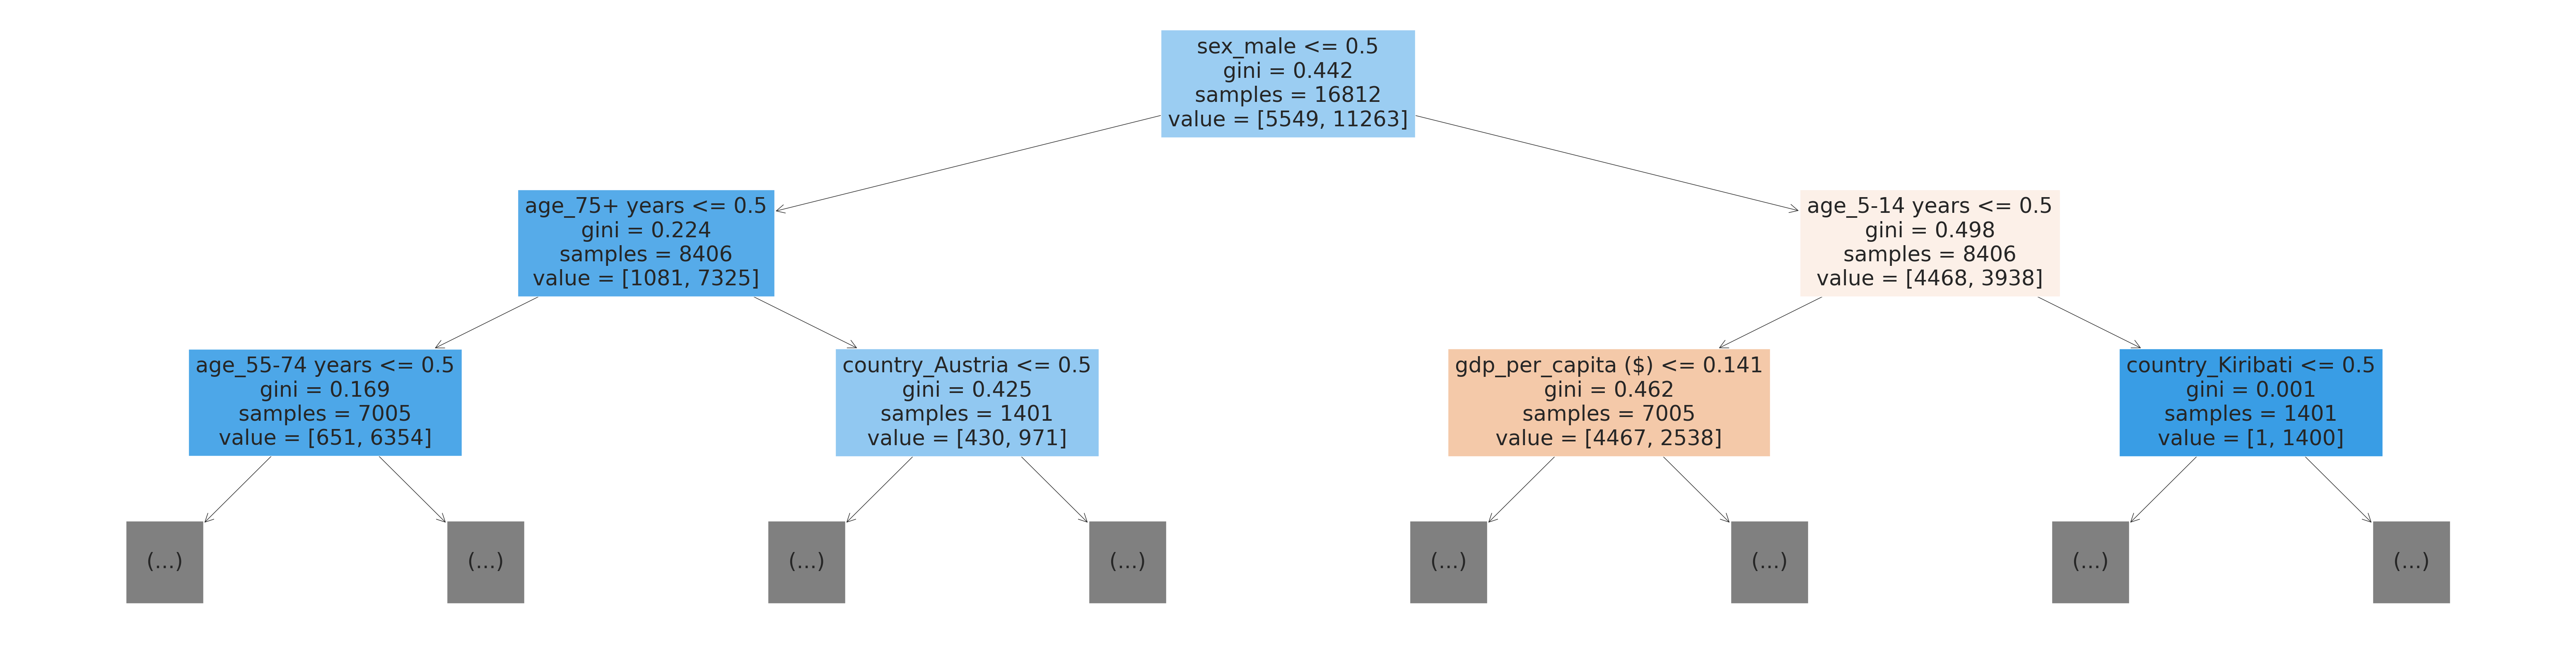

In [27]:
from sklearn.tree import plot_tree

plt.figure(figsize=(80, 20))
plot_tree(tree, feature_names=X_train.columns, max_depth=2, filled=True);

We can see that the model classifies the input data by a series of decisions. If a split results in information gain (measured by Gini Impurity Index - a lower Gini Index indicates a better split), the split will happen.

In our decision tree model, the input data was first split by sex, followed by age group, HDI for year, and country.

## Feature Importance

Based on the Gini index computation, each feature is assigned a "Gini importance", which is computed as the (normalized) total reduction of Gini index brought by that feature. Let's see which feature is more important to predict the suicide risk.



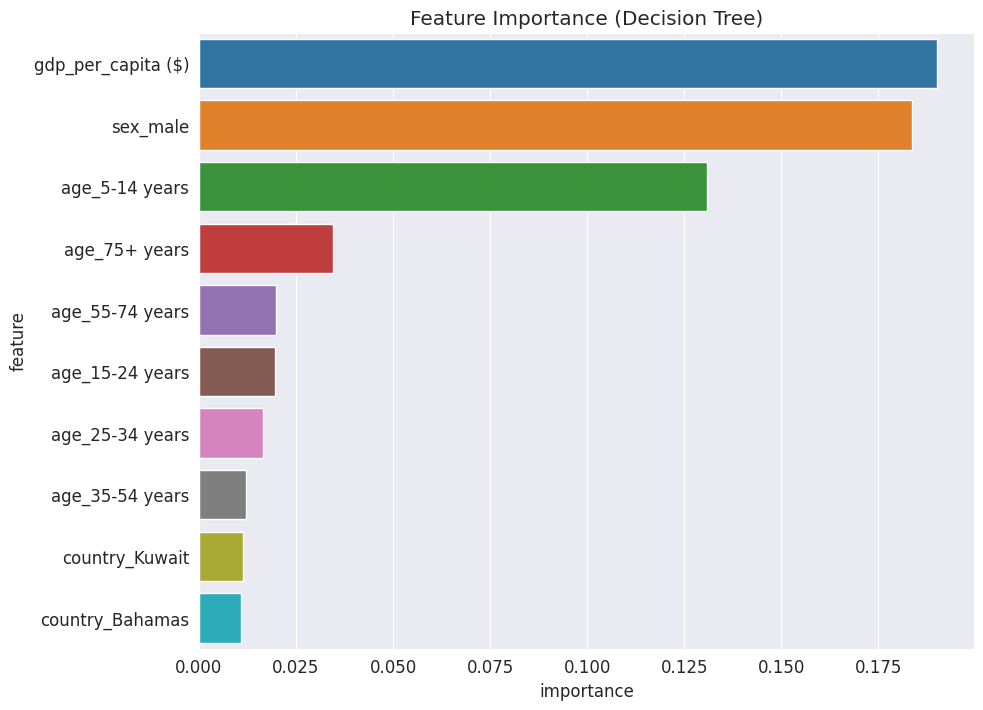

In [28]:
importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': tree.feature_importances_
}).sort_values(by='importance', ascending=False)

# Visualize the feature importance
sns.barplot(data=importance_df.head(10), x='importance', y='feature')
plt.title('Feature Importance (Decision Tree)');

The most important feature to predict the suicide risk is `sex_female` (0.18), followed by `HDI for year` and `age_5-14 years`, which both have similar importance of around 0.13. Other important features include `gdp_per_capita` and other age groups.

RANDOM FOREST

In [29]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_jobs=-1, random_state=1)
rf.fit(X_train, train_target)

RandomForestClassifier(n_jobs=-1, random_state=1)

## Evaluation

Let's look at the training accuracy and validation accuracy.

In [30]:
train_pred = rf.predict(X_train)
print('training accuracy: ', accuracy_score(train_target, train_pred))

val_pred = rf.predict(X_val)
print('validation accuracy: ', accuracy_score(val_target, val_pred))

training accuracy:  0.9999405186771354
validation accuracy:  0.900709219858156


The performance of the random forest model is actually pretty good. When using decision tree model earlier, our validation accuracy is around 85-89% with different tuning. Let's check the feature importance and see if it is comparable with the important features identifed from our single decision tree model.

## Feature Importance

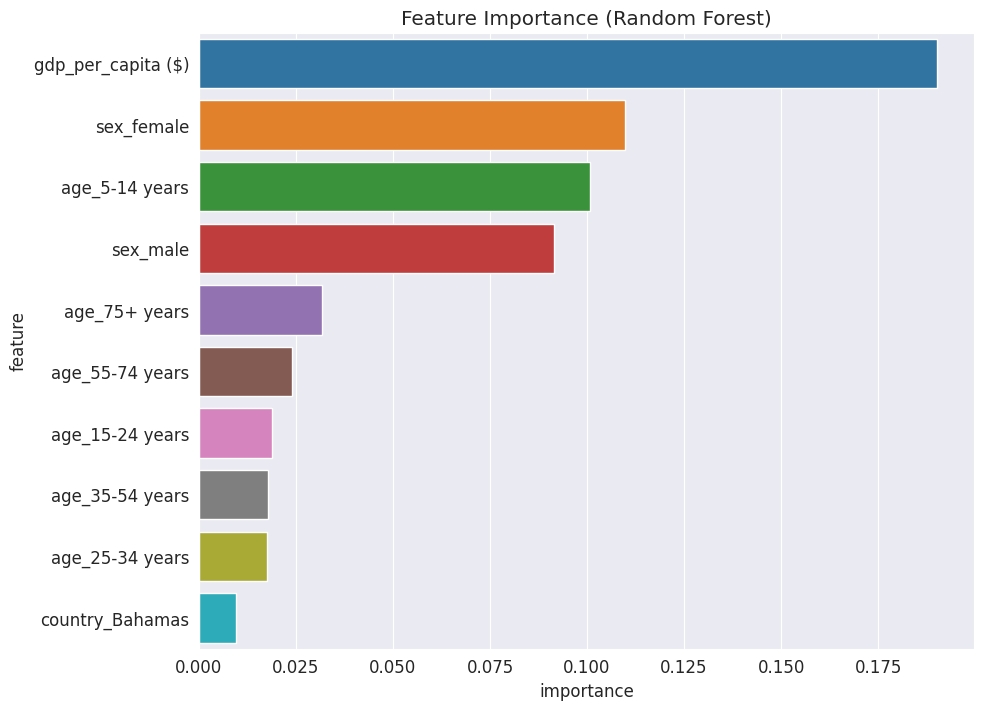

In [31]:
importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf.feature_importances_
}).sort_values(by='importance', ascending=False)

# Visualize the feature importance
sns.barplot(data=importance_df.head(10), x='importance', y='feature')
plt.title('Feature Importance (Random Forest)');

`gdp_per_capita ($)` turns out to be the most important feature in random forest model (4th important feature in decision tree model). The other important features (e.g., `sex_female`, `HDI for year`, `age_5-14 years`) are largely similar to the results from decision tree model.

## Visualization

Let's take a look at a few decision trees from the random forest. The decision trees can be accessed via `estimators_` attribute.

In [32]:
len(rf.estimators_)

100

Currently, we have 100 decision trees in the forest.

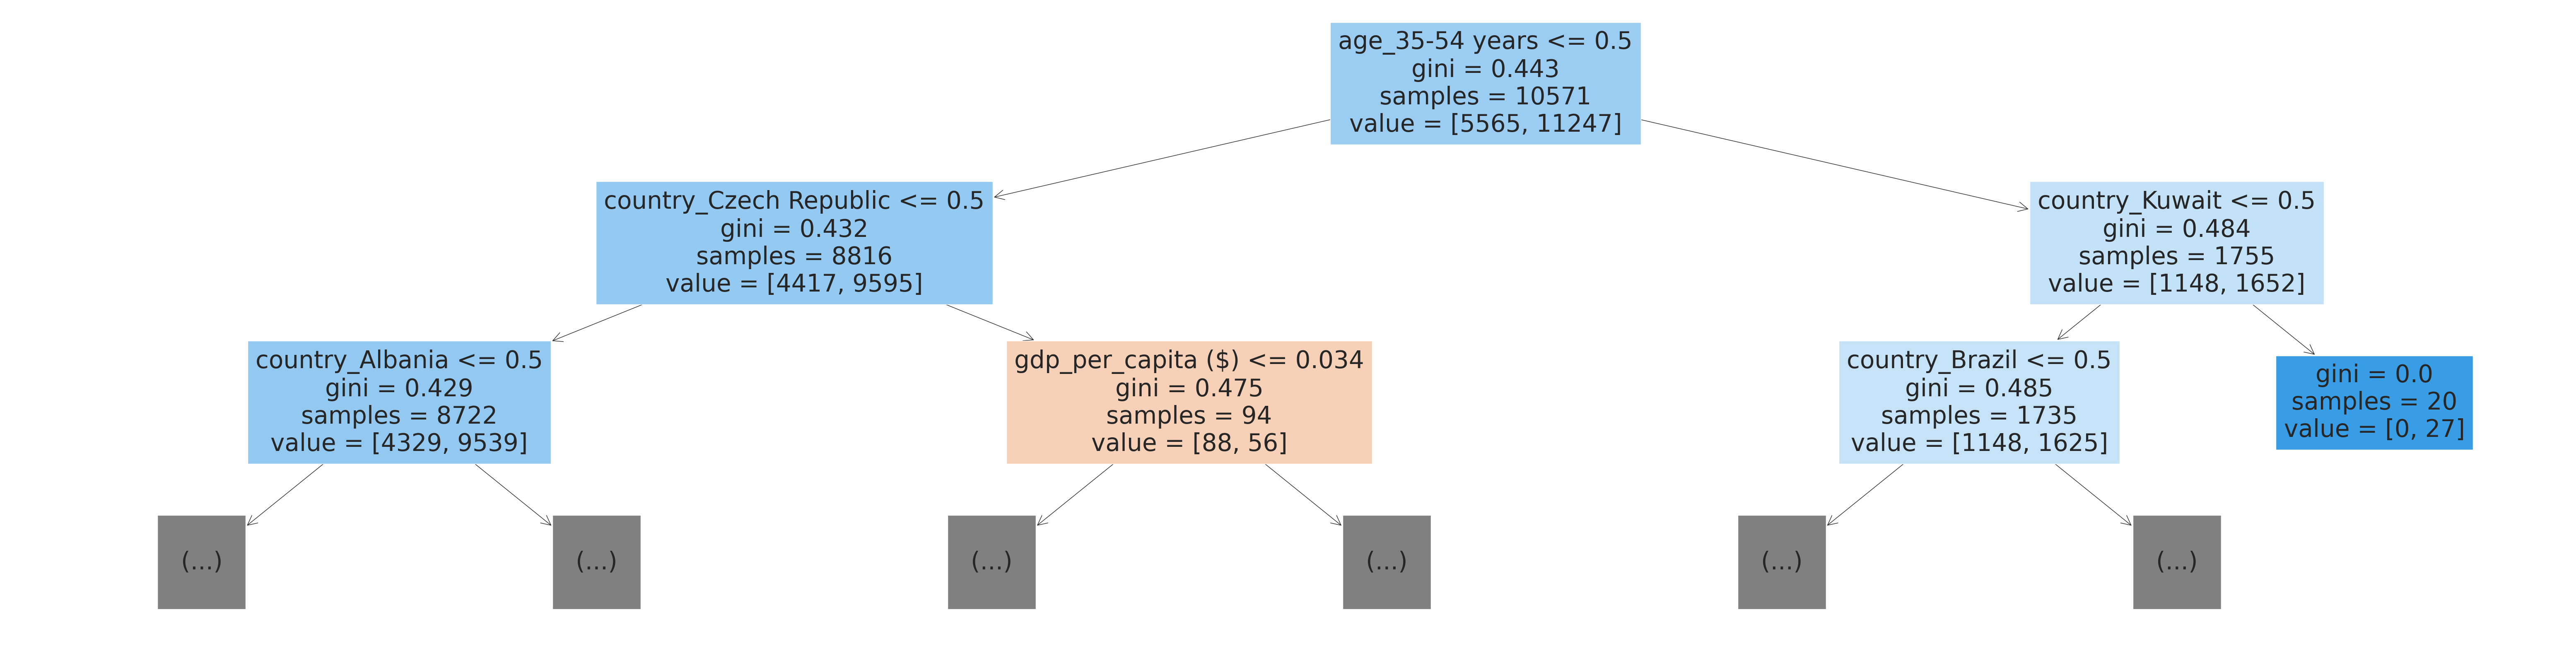

In [33]:
plt.figure(figsize=(80, 20))
plot_tree(rf.estimators_[0], feature_names=X_train.columns, max_depth=2, filled=True);

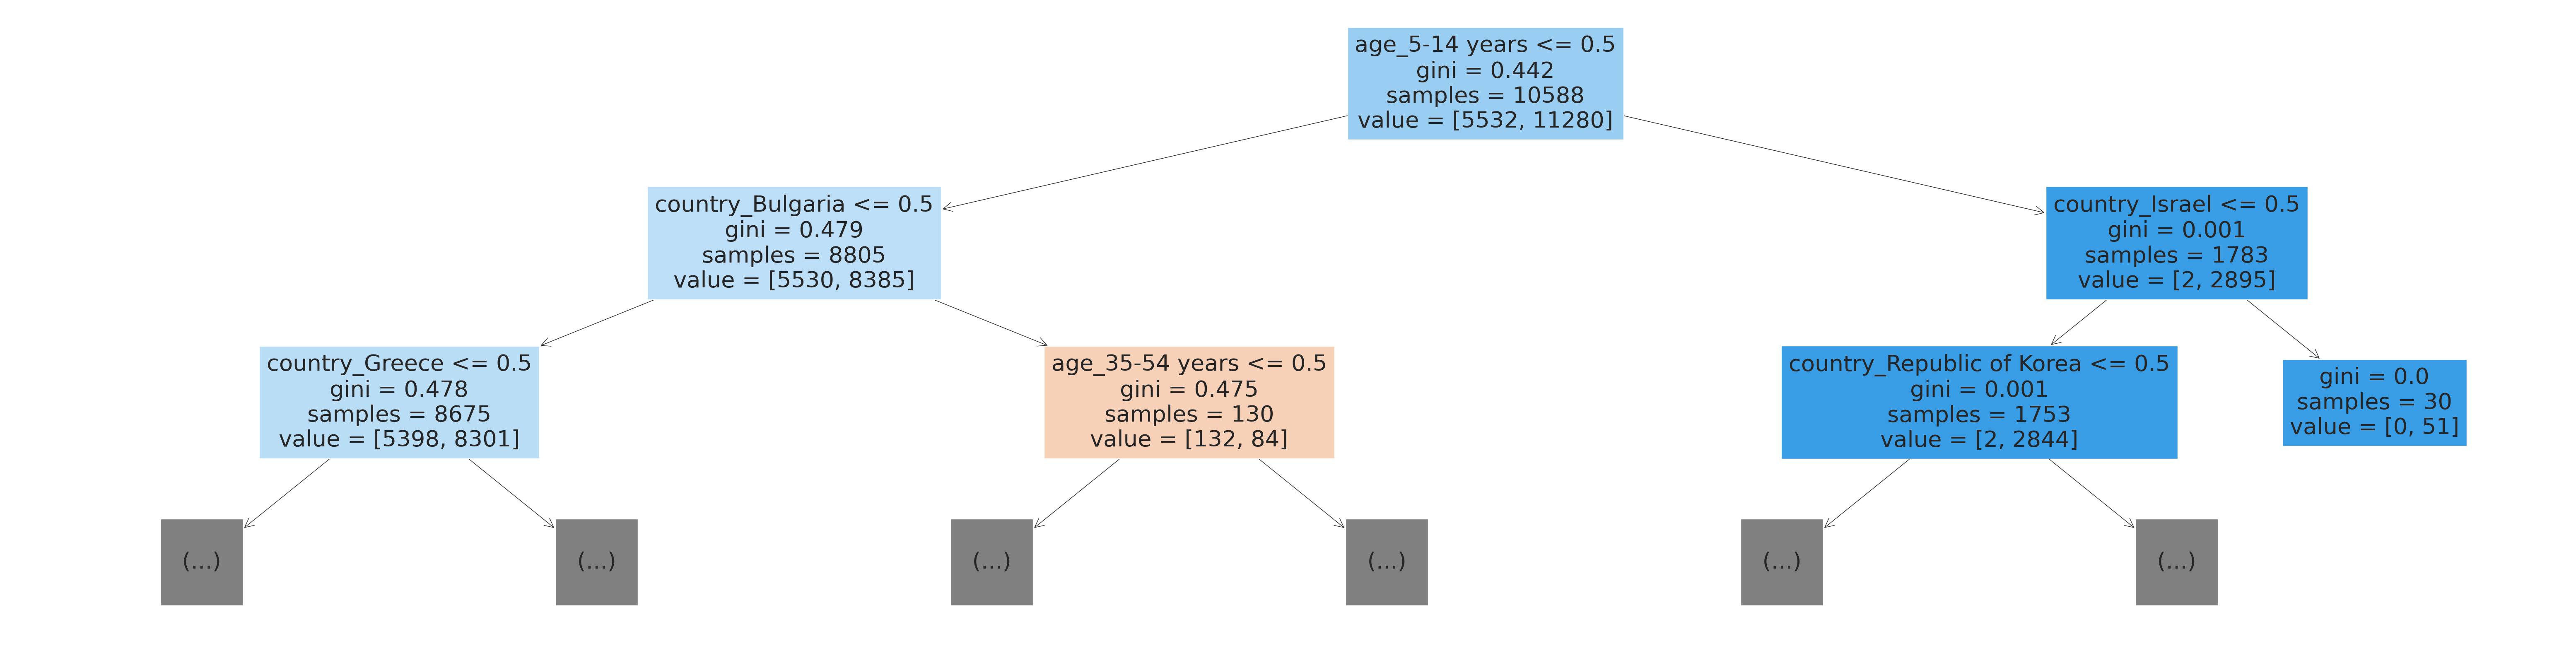

In [34]:
plt.figure(figsize=(80, 20))
plot_tree(rf.estimators_[1], feature_names=X_train.columns, max_depth=2, filled=True);

We can see that each decision tree is using different features to split the samples. This is because the dataset was built from various sub-samples of the dataset (attribute `bootstrap` was set as `True` by default). This "randomness" helps control overfitting.

#Conclusion
We've successfully trained a decision tree and a random forest model to predict the suicide risk based on factors such as age group, gender, GDP per capita and country.

It is important to recall that we do not have suicide data for most Asian and African countries in our training dataset. Hence, the ML models shall not be generalized beyond the countries available in our dataset.

Here are a few next steps we might take to better make predictions / generalize our model:

Collect data from more Asia and Africa countries
Obtain additional features such as employment status, financial situation (debt), any chronic health issues, country's mental health infrastructure, etc.
It's very difficult to obtain all the data for all the countries across the globe. We can also zoom into a particular country and collect / analyze the features more comprehensively. This might help us design targeted suicide prevention strategies for the higher-suicide risk group (e.g., include mental health education in secondary school, organize more community events for elderly, etc.).